#   **Projet Maths Info Horsin/Cattan**





Soit $f :  \mathbb{R^2} \to \mathbb{R}$   continûment différentiable  et $c \in \mathbb{R}$.

Le but du projet est de trouver l'ensemble $\{ \:(x,y) \:/ \:f(x,y)=c \: \}$.

# 1ère Partie: **Contour Simple**

## L'amorce

Nous avons choisi d'utiliser un algorithme dichotomique dans un premier temps, qui est plus robuste qu'un algorithme de Newton. En effet, n'ayant aucune information sur la valeur initiale (indispensable pour garantir la convergence), il semble plus cohérent d'utiliser une dichotomie.
 

In [1]:
def find_seed(f, c=0.0, x=0.0, eps = 2**(-26)):
    if not f(x,1.0)<= c <= f(x,0.0) and not f(x,0 )<= c <= f(x,1.0):
            return None  
    a = 0
    b = 1
    t = 0.5
    while abs(f(x,t)-c) > eps :  
        if (f(x,a)-c)*(f(x,t)-c) >= 0:
            a = t
        else :
            b = t
        t = (a+b)/2
    return t 

### Le contour simple

Pour la suite, nous allons définir quelques fonctions dont nous aurons besoin pour la fonction simple_contour.
Commençons par importer les bibliothèques utiles. Rappelons que dans cette section, nous supposons l'existence d'un premier point situé sur l'arête gauche du carré [0,1]x[0,1].

In [2]:
import matplotlib.pyplot as plt  
import autograd
from autograd import numpy as np

Définissons maintenant une fonction permettant de calculer une distance euclidienne dans $\mathbb{R^2}$

In [3]:
def distanceeucl(x, y):
    return np.sqrt(((x[0]-y[0])**2)+((x[1]-y[1])**2))

Définissons ensuite une fonction permettant de donner à un vecteur une norme souhaitée.

In [4]:
def normalisation(vecteur,normev): # l'idée est de rendre le vecteur unitaire puis de le multiplier par la norme souhaitée
    norme = distanceeucl(vecteur,(0,0))
    x = vecteur[0]
    y = vecteur[1]
    return (x*normev/norme, y*normev/norme)

Définissons enfin la fonction gradient qui calcule le gradient à l'aide de la bibliothèque autograd. 

In [5]:
def grad(f, x, y):
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]

## Comment obtenir les points le plus précisément possible ?

Rappelons que nous voulons trouver un fragment de ligne de niveau de valeur $c$ composés de points consécutivement espacés de $\delta$.

L'idée principale va être de réaliser un algorithme de Newton à un fonction $F_{n} : \mathbb{R^2} \to \mathbb{R^2}$ qui dépendra du dernier point trouvé via l'indice n et qui prendra en argument des couples (x,y) du plan.

Définissons cette fonction : 
$F_{n}(x,y) = \begin{pmatrix} f (x,y) - c = g\:(x,y)\\ (x-x_{n})^2 + (y-y_{n})^2 - \delta^2 = h_{n} (x,y)\end{pmatrix} $ 

Trouver un couple (x,y) annulant la fonction $F_{n}$ permet de trouver un point situé sur la ligne de niveau (condition n°1) ET distancé de $\delta$ du n-ième point précédemmet trouvé (condition n°2).

f étant continûment différentiable, les fonctions $g$ et $ h_{n}$ sont différentiables. En notant $ ( x_{n} , y_{n} ) $ le dernier point trouvé on a, en considérant les développements limités à l'odre 1 des fonctions $g$ et $h_{n}$ au point  $ ( x_{n} , y_{n} ) $ : 

$g(x,y) = g( x_{n} , y_{n} ) \: \: + \:\:\frac{\partial g}{\partial x}( x_{n} , y_{n} ) \:(x-x_{n}) \: + \: \frac{\partial g}{\partial y}( x_{n} , y_{n} ) \:(y-y_{n}) + o{(x,y)}$ 

$h_{n}(x,y) = h_{n}( x_{n} , y_{n} ) \: \: + \:\frac{\partial h_{n}}{\partial x}( x_{n} , y_{n} ) \: (x-x_{n}) \: + \: \frac{\partial h_{n}}{\partial y}( x_{n} , y_{n} ) \: (y-y_{n}) + o{(x,y)}$

En notant $J_{F_{n}}$ la jacobienne de la fonction $F_{n}$ définie par : 

$J_{F_{n}} = \begin{pmatrix} \frac{\partial g}{\partial x} & \frac{\partial g}{\partial y} \\ \frac{\partial h_{n}}{\partial x} & \frac{\partial h_{n}}{\partial y} \end{pmatrix}$

on obtient par approximation, dans le cadre de l'algorithme de Newton : 

$ \begin{pmatrix} 0 \\ 0 \end{pmatrix} = \begin{pmatrix} g( x_{n} , y_{n} ) \\ h_{n}( x_{n} , y_{n} ) \end{pmatrix} \: + J_{F_{n}} ( x_{n} , y_{n} ). \begin{pmatrix} (\:x-x_{n}\:) \\ (\: y-y_{n} \:) \end{pmatrix}$

Sous réserve d'inversion de $J_{F_{n}} ( x_{n} , y_{n} )$, il vient : 

$ \begin{pmatrix} x_{n+1} \\ y_{n+1} \end{pmatrix} = \begin{pmatrix} x_{n} \\ y_{n} \end{pmatrix} - J_{F_{n}} ( x_{n} , y_{n} )^-1 . \begin{pmatrix}  g( x_{n} , y_{n} )\\ h_{n}( x_{n} , y_{n} ) \end{pmatrix} $


C'est donc cette dernière égalité que nous implémenterons dans la fonction simple_contour. 

### Comment choisir le point d'initialisation pour l'algorithme de Newton ?

Pour faire cela, nous allons utiliser le résultat mathématique suivant : en un point où le gradient n'est pas nul, celui-ci oriente la normale à la surface définie par $\{ \:(x,y,z) \in \mathbb{R^3} \:/ \:f(x,y)=z \: \}$. Dans le cadre de notre problème, on se fixe à "l'altitude" $ z=c$, ce qui revient à considérer le problème plan. 

Il suffit alors de calculer le gradient au dernier point trouvé, d'en déterminer un vecteur orthogonal. Nous obtenons ainsi la direction de la tangente de f au dernier point trouvé. En donnant au vecteur tangent une norme $\delta$ assez petite, on peut connaître les coordoonées des deux points situés approximativement sur la ligne de niveau et distancé de $\delta$ du point précédent. 

Pour choisir entre ces deux points, on décide de prendre celui qui est le plus éloigné de l'avant-dernier point trouvé, de telle sorte d'éviter un "rebroussement" de la ligne de niveau. 
On choisit alors ce point pour implémenter l'algorithme de Newton, permettant de rendre sa convergence plus sûre. 

Cependant, cela nécessite d'avoir deux points initiaux avant de pouvoir lancer l'algorithme au complet. Pour faire cela, nous trouverons un premier point grâce à la fonction find_seed, puis nous déterminerons un second point en utilisant la méthode de la tangente et en choisissant le point s'éloignant le plus de la droite d'équation x=0.




Nous définissons ainsi la fonction simple_contour : 

In [6]:
def simple_contour(f,c=0.0,delta=0.01):
    #on commence par initialiser le programme en calculant les deux premiers points. 
    
    X = [0.0]  #on définit un premier point sur l'arête gauche à l'aide de find_seed
    if find_seed(f,c,0.0) != None:
        Y = [find_seed(f,c,0.0)]
    else:
        return "première valeur pas entre f(a) et f(b)"
    
    point_précédent = [X[-1],Y[-1]]
    gradient = grad(f, point_précédent[0], point_précédent[1]) #on calcule le gradient au premier point trouvé
    tangente = [-gradient[1], gradient[0]] #le gradient dirige la normale à la tangente.
    tangente_normalisée = normalisation(tangente, delta) #la norme du vecteur tangent est delta
    
    if tangente_normalisée[0] >= 0 :  #on vérifie que le point choisi en second partira bien vers la droite (x>=0)
        deuxième_point = (point_précédent[0] + tangente_normalisée[0],
                          point_précédent[1] + tangente_normalisée[1]
                         )
    else : 
        deuxième_point = (point_précédent[0] - tangente_normalisée[0],
                          point_précédent[1] - tangente_normalisée[1]
                         )
         
    nouveau_point = np.array(deuxième_point)
    def F(x, y): #on définit le système à 2 équations
        return np.array([f(x,y) - c,(x - point_précédent[0])**2 + (y - point_précédent[1])**2 - delta**2])
        
    def Jacob(F, x, y):  #on définit la jacobienne.
        j = autograd.jacobian
        return np.c_[j(F,0)(x, y),j(F,1)(x, y)]
    
    A = F( nouveau_point[0],  nouveau_point[1])   #matrice associéé au système 2x2
    
    while distanceeucl(A,[0,0]) >= 2**(-10) :
        nouveau_point =  nouveau_point - np.linalg.inv(Jacob(F,  nouveau_point[0], nouveau_point[1])).dot(np.array(A))
        A = F( nouveau_point[0],  nouveau_point[1])
    X += [ nouveau_point[0]]
    Y += [ nouveau_point[1]]
    
    
    while X[-1] <= 1 and Y[-1] <= 1 and X[-1] >= 0 and Y[-1] >= 0: #la condition d'arrêt est la sortie du carré [0,1]x[0,1]
        distance = []
        point_précédent = [X[-1], 
                           Y[-1]
                          ]
    
        gradient = grad(f, point_précédent[0], point_précédent[1])
        tangente=[-gradient[1],gradient[0]]
        tangente_normalisée = normalisation(tangente,delta)
        point1 = [point_précédent[0] + tangente_normalisée[0], #on détermine le premier point candidat.
                  point_précédent[1] + tangente_normalisée[1]
                 ]
        
        point2 = [point_précédent[0] - tangente_normalisée[0], #on détermine le second point candidat.
                  point_précédent[1] - tangente_normalisée[1]]
        liste_point = [point1, point2]
        
        for i in liste_point:            
            distance += [distanceeucl((X[-2], Y[-2]), i)]
            
        e = distance.index(max(distance)) #on choisit le point le plus éloigné de l'avant-dernier point 
        nouveau_point = np.array(liste_point[e]) # il permet d'initialiser Newton. 
        def F(x, y): #on définit le système à 2 équations
            return np.array([f(x,y) - c,(x - point_précédent[0])**2 + (y - point_précédent[1])**2 - delta**2])
        
        def Jacob(F, x, y):  #on définit la jacobienne.
            j = autograd.jacobian
            return np.c_[j(F,0)(x, y),j(F,1)(x, y)]
        
        A = F(nouveau_point[0], nouveau_point[1])   # on évalue F au point intermédiaire.
        
        while distanceeucl(A,[0,0]) >= 2**(-10): # on cherche un zéro de F.
            A = F(nouveau_point[0],nouveau_point[1])
            nouveau_point = nouveau_point - np.linalg.inv(Jacob(F, nouveau_point[0], nouveau_point[1])).dot(np.array(A))
        X += [nouveau_point[0]]
        Y += [nouveau_point[1]]
    X.pop() #on enlève le dernier point qui était situé hors du carré [0,1]x[0,1]
    Y.pop()
    return [X, Y]

On peut maintenant définir des fonctions tests, et tester ce premier programme sur ces fonctions tests. 

In [7]:
def f(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

def h(x,y):
    return x**2 + (y-0.4)**2

[[0.0, 0.01, 0.019997500937116313, 0.0299875084310548, 0.0399650355845191, 0.049925105462966524, 0.059862753565063924, 0.06977303028263272, 0.07965100334888056, 0.08949176027372632, 0.09900671623738601, 0.10875857940115195, 0.1184585145270701, 0.1281016882527784, 0.1376832991815311, 0.1471985802388173, 0.15664280100774206, 0.1660112700420534, 0.17529933715571258, 0.18450239568791937, 0.1930999887619118, 0.2021197558060744, 0.2110407428897084, 0.21985851753534374, 0.22856870212737593, 0.23716697602859427, 0.2456490776645897, 0.25401080657507447, 0.26224802543116543, 0.2703566620177028, 0.2776102174505349, 0.28545026109387184, 0.2931495750432637, 0.30070434767831467, 0.30811084241409353, 0.31536539947253456, 0.32246443761242793, 0.3294044558172305, 0.33618203493994997, 0.34279383930437957, 0.348343382245101, 0.3546146217714975, 0.3607101659145747, 0.3666270130716919, 0.3723622531254595, 0.3779130687821026, 0.38327673686117936, 0.38845062953612086, 0.39343221552508517, 0.39821906123164286

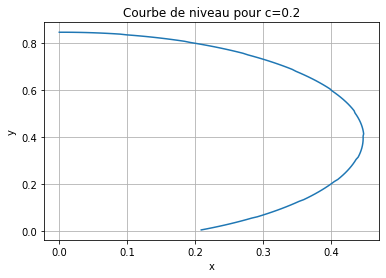

In [8]:
c=0.2
data=simple_contour(h,float(c))
print(data)
plt.plot(data[0],data[1])
plt.grid()
plt.title(f"Courbe de niveau pour c={float(c)}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 2ème partie : Contour complexe

On définit des fonctions find_seed intermédiaires afin de faire des recherches de premiers points sur les 4 bords des petits carrés qui constitueront le cadrillage final. 

In [9]:
def find_seedx(f, c=0.0, x=0.0, y1 = 0.0, y2 = 1.0, eps = 2**(-26)): # cette fonction permet à x fixé, de chercher un y
    if not f(x,y1)<= c <= f(x,y2) and not f(x,y2)<= c <= f(x, y1):  # compris entre y1 et y2 tel que f(x,y)=c
            return None  
    a = y1
    b = y2
    t = (a+b)/2 
    while abs(f(x,t)- c) > eps :  
        if (f(x, a) - c)*(f(x,t) - c) >= 0:
            a = t
        else :
            b = t
        t = (a+b)/2
    return t 

In [10]:
def find_seedy(f, c=0.0, y=0.0, x1 = 0.0, x2 = 1.0, eps = 2**(-26)): # cette fonction permet à y fixé, de chercher un x
    if not f(x1, y)<= c <= f(x2, y) and not f(x2, y)<= c <= f(x1, y): # compris entre x1 et x2 
            return None  
    a = x1
    b = x2
    t = (a+b)/2
    while abs(f(t, y)-c) > eps :  
        if (f(a, y)-c)*(f(t, y)-c) >= 0:
            a = t
        else :
            b = t
        t = (a+b)/2
    return t 

On modifie légèrement le début de la fonction contour_simple afin de chercher des valeurs sur les 4 bords, en faisant appel aux fonctions find_seed précédemment définies.

In [11]:
def simple_contourmodif(f,c=0.0,delta=0.01, x1 = 0.0, x2 = 1.0, y1 = 0.0, y2 = 1.0):
    coté_X = [x1, x2]
    coté_Y = [y1, y2]
    test_coté = False
    for i in coté_X: #on réalise une recherche de premier point sur les droite d'équation x=x1 et x=x2 
        a = find_seedx(f, c, i, y1, y2)
        if a != None:
            X = [i]
            Y = [a]
            test_coté = True
            
    for i in coté_Y: #on réalise une recherche de premier point sur les droites d'équation y=y1 et y=y2
        a = find_seedy(f, c, i, x1, x2)
        if a != None:
            Y = [i]
            X = [a]
            test_coté = True
            
    if test_coté == False: #si aucun point n'a été trouvé sur les bords, on retourne des listes vides. 
        return [[],[]]
    
    
    point_précédent = [X[-1],Y[-1]]
    gradient = grad(f, point_précédent[0], point_précédent[1]) #on calcule le gradient au premier point trouvé
    tangente = [-gradient[1], gradient[0]] #le gradient dirige la normale à la tangente.
    tangente_normalisée = normalisation(tangente, delta) #la norme du vecteur tangent est delta
    
    if x1 <= (point_précédent[0] + tangente_normalisée[0]) <= x2 and  y1 <= point_précédent[1] + tangente_normalisée[1] <= y2:  #on vérifie que le point choisi en second partira bien vers la droite (x>=0)
        deuxième_point = (point_précédent[0] + tangente_normalisée[0],
                          point_précédent[1] + tangente_normalisée[1]
                         )
    else : 
        deuxième_point = (point_précédent[0] - tangente_normalisée[0],
                          point_précédent[1] - tangente_normalisée[1]
                         )
         
    nouveau_point = np.array(deuxième_point)
    def F(x, y): #on définit le système à 2 équations
        return np.array([f(x,y) - c,(x - point_précédent[0])**2 + (y - point_précédent[1])**2 - delta**2])
        
    def Jacob(F, x, y):  #on définit la jacobienne.
        j = autograd.jacobian
        return np.c_[j(F,0)(x, y),j(F,1)(x, y)]
    
    A = F( nouveau_point[0],  nouveau_point[1])   #matrice associéé au système 2x2
    
    while distanceeucl(A,[0,0]) >= 2**(-10) :
        nouveau_point =  nouveau_point - np.linalg.inv(Jacob(F,  nouveau_point[0], nouveau_point[1])).dot(np.array(A))
        A = F( nouveau_point[0],  nouveau_point[1])
    X += [ nouveau_point[0]]
    Y += [ nouveau_point[1]]
    
    
    while X[-1] <= x2 and Y[-1] <= y2  and X[-1] >= x1 and Y[-1] >= y1 :
        distance = []
        point_précédent = [X[-1], 
                           Y[-1]
                          ]
    
        gradient = grad(f, point_précédent[0], point_précédent[1])
        tangente=[-gradient[1],gradient[0]]
        tangente_normalisée = normalisation(tangente,delta)
        point1 = [point_précédent[0] + tangente_normalisée[0],
                  point_précédent[1] + tangente_normalisée[1]
                 ]
        
        point2 = [point_précédent[0] - tangente_normalisée[0],
                  point_précédent[1] - tangente_normalisée[1]]
        liste_point = [point1, point2]
        
        for i in liste_point:            
            distance += [distanceeucl((X[-2], Y[-2]), i)]
            
        e = distance.index(max(distance))       
        nouveau_point = np.array(liste_point[e])
        
        def F(x, y): #on définit le système à 2 équations
            return np.array([f(x,y) - c,(x - point_précédent[0])**2 + (y - point_précédent[1])**2 - delta**2])
        
        def Jacob(F, x, y):  #on définit la jacobienne.
            j = autograd.jacobian
            return np.c_[j(F,0)(x, y),j(F,1)(x, y)]
        
        A = F(nouveau_point[0], nouveau_point[1])   
        
        while distanceeucl(A,[0,0]) >= 2**(-10):            
            A = F(nouveau_point[0],nouveau_point[1])
            nouveau_point = nouveau_point - np.linalg.inv(Jacob(F, nouveau_point[0], nouveau_point[1])).dot(np.array(A))
        X += [nouveau_point[0]]
        Y += [nouveau_point[1]]
    return [X, Y]

Puis on définit la fonction contour finale qui fera appel à la nouvelle fonction simple_contourmodif précédemment définie.

In [12]:
def contour(f,c, xc = [0.0,1.0], yc = [0.0,1.0], delta = 0.01): #la fonction prend en argument le quadrillage défini par les listes xc et yc.
    X_tot = []
    Y_tot = []
    for i in range(len(yc) - 1):
        for j in range(len(xc)-1): #dans chaque petit rectangle, on applique simple_contourmodif.
            xg = xc[j]
            xd = xc[j+1]
            yg = yc[i]
            yd = yc[i+1]
            R = simple_contourmodif(f, c, delta , xg, xd, yg, yd)
            X_tot.append(R[0])
            Y_tot.append(R[1])
    return [X_tot, Y_tot]

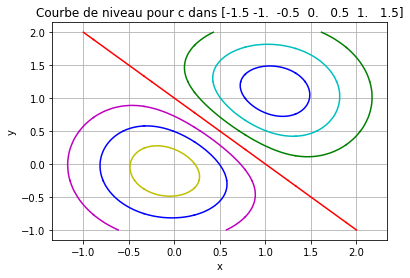

In [13]:

xc = np.linspace(-2,3,10) #on définit le quadrillage relatif à la fonction exemple f
yc = np.linspace(-1,2,5)
valeur = np.arange(-1.5, 2, 0.5) #on définit les différentes valeur de c.
v = ["b","c","g","r","m","b","y"]
for i in range(len(valeur)):
    data = contour(f,float(valeur[i]), xc, yc)
    for x,y in zip(data[0],data[1]):
        plt.plot(x, y, color = v[i])
plt.grid()
plt.title(f"Courbe de niveau pour c dans {valeur}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()